In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pydataset import data

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import wrangle as w

# Exercises
## 1. Load the tips dataset

In [2]:
tips_df = data('tips')
tips_df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
tips_df = tips_df.rename(columns={'size':'persons'})

### a. Create a column named price_per_person. This should be the total bill divided by the party size.

In [4]:
tips_df['price_per_person'] = tips_df.total_bill / tips_df.persons
tips_df.head()

,total_bill,tip,sex,smoker,day,time,persons,price_per_person
1,16.99,1.01,Female,No,Sun,Dinner,2,8.495000
2,10.34,1.66,Male,No,Sun,Dinner,3,3.446667
3,21.01,3.50,Male,No,Sun,Dinner,3,7.003333
4,23.68,3.31,Male,No,Sun,Dinner,2,11.840000
5,24.59,3.61,Female,No,Sun,Dinner,4,6.147500


### b. Before using any of the methods discussed in the lesson, which features do you think would be most important for predicting the tip amount?
    - total_bill. after that, it's hard to say; best guess (in order): time, sex, day, size, smoker

### Before moving on to c, I am going to clean up/order the column names and scale the columns to make it usable for the feature engineering / selection work

In [5]:
cols_in_order = ['total_bill', 'persons', 'price_per_person', 'time', 'sex', 'day', 'smoker', 'tip']
tips_df = tips_df[cols_in_order]
tips_df.head()

,total_bill,persons,price_per_person,time,sex,day,smoker,tip
1,16.99,2,8.495000,Dinner,Female,Sun,No,1.01
2,10.34,3,3.446667,Dinner,Male,Sun,No,1.66
3,21.01,3,7.003333,Dinner,Male,Sun,No,3.50
4,23.68,2,11.840000,Dinner,Male,Sun,No,3.31
5,24.59,4,6.147500,Dinner,Female,Sun,No,3.61


In [6]:
tips_df.shape

(244, 8)

In [7]:
# get dummy columns for categorical variables
dummy_df = pd.get_dummies(tips_df[['time', 'sex', 'day', 'smoker']], drop_first=True)
tips_df = pd.concat([tips_df, dummy_df], axis=1)
tips_df.head()

,total_bill,persons,price_per_person,time,sex,day,smoker,tip,time_Lunch,sex_Male,day_Sat,day_Sun,day_Thur,smoker_Yes
1,16.99,2,8.495000,Dinner,Female,Sun,No,1.01,0,0,0,1,0,0
2,10.34,3,3.446667,Dinner,Male,Sun,No,1.66,0,1,0,1,0,0
3,21.01,3,7.003333,Dinner,Male,Sun,No,3.50,0,1,0,1,0,0
4,23.68,2,11.840000,Dinner,Male,Sun,No,3.31,0,1,0,1,0,0
5,24.59,4,6.147500,Dinner,Female,Sun,No,3.61,0,0,0,1,0,0


In [8]:
# split into train, validate, and test so I can use my scaling function
train, validate, test = w.split_function(tips_df)

Prepared df: (244, 14)

Train: (146, 14)
Validate: (49, 14)
Test: (49, 14)


In [9]:
# set columns to scale (numeric aka continuous variable columns)
to_scale = ['total_bill','persons', 'price_per_person']

# scale with MinMaxScaler
train_scaled, validate_scaled, test_scaled = w.get_minmax_scaled(train, validate, test, to_scale)
train_scaled.head()

,total_bill,persons,price_per_person,time,sex,day,smoker,tip,time_Lunch,sex_Male,day_Sat,day_Sun,day_Thur,smoker_Yes
101,0.094123,0.2,0.149744,Dinner,Female,Fri,Yes,2.50,0,0,0,0,0,1
183,0.874656,0.4,0.839421,Dinner,Male,Sun,Yes,3.50,0,1,0,1,0,1
49,0.488981,0.4,0.430363,Dinner,Male,Sun,No,2.05,0,1,0,1,0,0
119,0.118916,0.2,0.189189,Lunch,Female,Thur,No,1.80,1,0,0,0,1,0
62,0.150597,0.2,0.239591,Dinner,Male,Sat,Yes,2.00,0,1,1,0,0,1


In [10]:
# isolate just the scaled columns and the target
train_scaled = train_scaled.drop(columns=['time', 'sex', 'day', 'smoker'])
validate_scaled = validate_scaled.drop(columns=['time', 'sex', 'day', 'smoker'])
test_scaled = test_scaled.drop(columns=['time', 'sex', 'day', 'smoker'])
train_scaled.head()

,total_bill,persons,price_per_person,tip,time_Lunch,sex_Male,day_Sat,day_Sun,day_Thur,smoker_Yes
101,0.094123,0.2,0.149744,2.50,0,0,0,0,0,1
183,0.874656,0.4,0.839421,3.50,0,1,0,1,0,1
49,0.488981,0.4,0.430363,2.05,0,1,0,1,0,0
119,0.118916,0.2,0.189189,1.80,1,0,0,0,1,0
62,0.150597,0.2,0.239591,2.00,0,1,1,0,0,1


In [11]:
# separate into X and y
X_train_scaled = train_scaled[train_scaled.columns[train_scaled.columns != 'tip']]
X_validate_scaled = validate_scaled[validate_scaled.columns[validate_scaled.columns != 'tip']]
X_test_scaled = test_scaled[test_scaled.columns[test_scaled.columns != 'tip']]
X_train_scaled.head()

,total_bill,persons,price_per_person,time_Lunch,sex_Male,day_Sat,day_Sun,day_Thur,smoker_Yes
101,0.094123,0.2,0.149744,0,0,0,0,0,1
183,0.874656,0.4,0.839421,0,1,0,1,0,1
49,0.488981,0.4,0.430363,0,1,0,1,0,0
119,0.118916,0.2,0.189189,1,0,0,0,1,0
62,0.150597,0.2,0.239591,0,1,1,0,0,1


In [12]:
y_train = train.tip
y_validate = validate.tip
y_test = test.tip
y_train[:5]

101    2.50
183    3.50
49     2.05
119    1.80
62     2.00
Name: tip, dtype: float64

### c. Use select k best to select the top 2 features for predicting tip amount. What are they?
- total_bill and persons (renamed from size)

In [13]:
f_selector = SelectKBest(f_regression, k=2)

In [14]:
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x1611dd820>)

In [15]:
# boolean mask of whether the column was selected or not
feature_mask = f_selector.get_support()
feature_mask

array([ True,  True, False, False, False, False, False, False, False])

In [16]:
# which columns were the top 2 (k=2)
X_train_scaled[X_train_scaled.columns[feature_mask]].columns

Index(['total_bill', 'persons'], dtype='object')

In [17]:
def get_kbest_multi (X_train_scaled, y_train):
    """
    This function will
    - accept X_train_scaled, a dataframe with scaled columns ready to check for which of those columns (features) 
        will be most useful to predict the values in y_train which is the target
    - return a dataframe with results of top features, iterating over k = 1 to number of columns
    """
    # Initialize col_list to capture rank-ordered columns (features)
    col_list = []
    
    # loop through checking for k best columns where k = 1 - n (number of columns)
    n = len(X_train_scaled.columns.to_list())
    for i in range(0, n):
 
        # make the thing and fit the thing
        f_selector = SelectKBest(f_regression, k=i+1)
        f_selector.fit(X_train_scaled, y_train)

        # get the mask so we know which are the k-best features
        feature_mask = f_selector.get_support()
        
        # code to add the next best feature to col_list
        for c in X_train_scaled[X_train_scaled.columns[feature_mask]].columns:
            if c not in col_list:
                col_list = col_list + [c]
    
    # make and return dataframe with results
    rank = list(range(1,len(col_list)+1))
    scores = f_selector.scores_
    scores = sorted(scores, reverse=True)
    results_df = pd.DataFrame({'Feature':col_list, 
                               'KBest Rank': rank, 
                               'KBest Scores': scores})
    return results_df


In [18]:
get_kbest_multi(X_train_scaled, y_train)

,Feature,KBest Rank,KBest Scores
0,total_bill,1,100.725447
1,persons,2,42.553258
2,price_per_person,3,15.878404
3,day_Sun,4,5.521484
4,time_Lunch,5,4.395615
5,day_Thur,6,2.048218
6,sex_Male,7,1.648387
7,day_Sat,8,0.233975
8,smoker_Yes,9,0.047179


### d. Use recursive feature elimination to select the top 2 features for tip amount. What are they?
- total_bill and price_per_person

### e. Why do you think select k best and recursive feature elimination might give different answers for the top features? 
- I don't know.

### Does this change as you change the number of features you are selecting?
- It did change. The top feature was the same, but numbers 2 and 3 were swapped. Then it was fairly different after that between KBest and RFE


In [19]:
# initialize LinearRegression model
lr = LinearRegression()

In [20]:
# make the thing:
#  create RFE (Recursive Feature Elimination) object
#  indicating lr model and number of features to select = 2
rfe = RFE(lr, n_features_to_select=2)

In [21]:
# fit the thing:
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [22]:
rfe.support_

array([ True, False,  True, False, False, False, False, False, False])

In [23]:
# view a list of columns and their rank
feature_rank = rfe.ranking_
feature_rank

array([1, 2, 1, 4, 6, 3, 8, 5, 7])

In [24]:
rfe.score(X_train_scaled, y_train)

0.4283456826778629

In [25]:
rfe_ranking_df = pd.DataFrame({'Feature': X_train_scaled.columns,
                               'RFE Rank': feature_rank})
rfe_ranking_df.sort_values('RFE Rank')

,Feature,RFE Rank
0,total_bill,1
2,price_per_person,1
1,persons,2
5,day_Sat,3
3,time_Lunch,4
7,day_Thur,5
4,sex_Male,6
8,smoker_Yes,7
6,day_Sun,8


In [26]:
def get_rfe_multi (X_train_scaled, y_train):
    """
    This function will
    - accept X_train_scaled, a dataframe with scaled columns ready to check for which of those columns (features) 
        will be most useful to predict the values in y_train which is the target
    - return a dataframe with results of top features, iterating over k = 1 to number of columns
    """
 
    # initialize LinearRegression model
    lr = LinearRegression()

    # make the thing and fit the thing
    rfe = RFE(lr, n_features_to_select=1)
    rfe.fit(X_train_scaled, y_train)

    feature_rank = rfe.ranking_
    results_df = pd.DataFrame({'Feature': X_train_scaled.columns,
                                   'RFE Rank': feature_rank})
    return results_df.sort_values('RFE Rank')

In [27]:
get_rfe_multi(X_train_scaled, y_train)

,Feature,RFE Rank
0,total_bill,1
2,price_per_person,2
1,persons,3
5,day_Sat,4
3,time_Lunch,5
7,day_Thur,6
4,sex_Male,7
8,smoker_Yes,8
6,day_Sun,9


In [28]:
get_kbest_multi(X_train_scaled, y_train)

,Feature,KBest Rank,KBest Scores
0,total_bill,1,100.725447
1,persons,2,42.553258
2,price_per_person,3,15.878404
3,day_Sun,4,5.521484
4,time_Lunch,5,4.395615
5,day_Thur,6,2.048218
6,sex_Male,7,1.648387
7,day_Sat,8,0.233975
8,smoker_Yes,9,0.047179


## 2. Write a function named select_kbest that takes in the predictors (X), the target (y), and the number of features to select (k) and returns the names of the top k selected features based on the SelectKBest class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [29]:
def select_kbest (X_train_scaled, y_train, k):
    """
    This function will
    - accept 
        -- X_train_scaled, a dataframe with scaled columns ready to check for which of those columns (features) 
        will be most useful to predict the values in y_train which is the target
        -- y_train, the target series
        -- k, the number of top features to return
    - makes and fits a SelectKBest object to evaluate which features are the best
    - returns a list with the column names of the top k columns (features)
    """
     
    # make the thing and fit the thing
    f_selector = SelectKBest(f_regression, k=k)
    f_selector.fit(X_train_scaled, y_train)

    # get the mask so we know which are the k-best features
    feature_mask = f_selector.get_support()
        
    # get the columns associated with the top k features
    results_list = X_train_scaled[X_train_scaled.columns[feature_mask]].columns.to_list()

    return results_list

In [30]:
select_kbest(X_train_scaled, y_train, 2)

['total_bill', 'persons']

## 3. Write a function named rfe that takes in the predictors, the target, and the number of features to select. It should return the top k features based on the RFE class. Test your function with the tips dataset. You should see the same results as when you did the process manually.

In [31]:
def select_rfe (X_train_scaled, y_train, k):
    """
    This function will
    - accept 
        -- X_train_scaled, a dataframe with scaled columns ready to check for which of those columns (features) 
        will be most useful to predict the values in y_train which is the target
        -- y_train, the target series
        -- k, the number of top features to return
    - makes and fits a RFE (Recursive Feature Elimination) object with a LinearRegressiion model
        to evaluate which features are the best
    - returns a list with the column names of the top k columns (features)
    """
    
    # initialize LinearRegression model
    lr = LinearRegression()
    
    # make the thing:
    #  create RFE (Recursive Feature Elimination) object
    #  indicating lr model and number of features to select = k
    rfe = RFE(lr, n_features_to_select=k)
    
    # fit the thing:
    rfe.fit(X_train_scaled, y_train)
    
    # make a mask to select columns
    feature_mask = rfe.support_
    
    results_list = X_train_scaled[X_train_scaled.columns[feature_mask]].columns.to_list()
    
    return results_list

In [32]:
select_rfe (X_train_scaled, y_train, 2)

['total_bill', 'price_per_person']

## Load the swiss dataset and use all the other features to predict Fertility. Find the top 3 features using both select k best and recursive feature elimination (use the functions you just built to help you out).

In [33]:
df = data('swiss')

In [34]:
df = df.reset_index()
df.columns = ['region','fertility', 'agriculture', 'examination', 'education', 'catholic', 'infant_mortality']

In [35]:
df.head()

,region,fertility,agriculture,examination,education,catholic,infant_mortality
0,Courtelary,80.2,17.0,15,12,9.96,22.2
1,Delemont,83.1,45.1,6,9,84.84,22.2
2,Franches-Mnt,92.5,39.7,5,5,93.40,20.2
3,Moutier,85.8,36.5,12,7,33.77,20.3
4,Neuveville,76.9,43.5,17,15,5.16,20.6


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            47 non-null     object 
 1   fertility         47 non-null     float64
 2   agriculture       47 non-null     float64
 3   examination       47 non-null     int64  
 4   education         47 non-null     int64  
 5   catholic          47 non-null     float64
 6   infant_mortality  47 non-null     float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.7+ KB


In [37]:
df.region.nunique()

47

In [38]:
df.describe()

,fertility,agriculture,examination,education,catholic,infant_mortality
count,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000
mean,70.142553,50.659574,16.489362,10.978723,41.14383,19.942553
std,12.491697,22.711218,7.977883,9.615407,41.70485,2.912697
min,35.000000,1.200000,3.000000,1.000000,2.15000,10.800000
25%,64.700000,35.900000,12.000000,6.000000,5.19500,18.150000
50%,70.400000,54.100000,16.000000,8.000000,15.14000,20.000000
75%,78.450000,67.650000,22.000000,12.000000,93.12500,21.700000
max,92.500000,89.700000,37.000000,53.000000,100.00000,26.600000


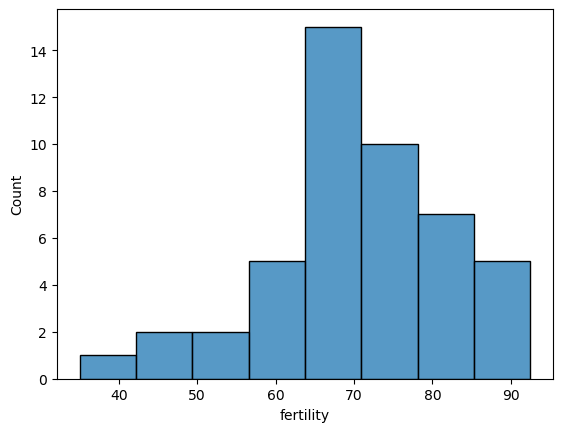

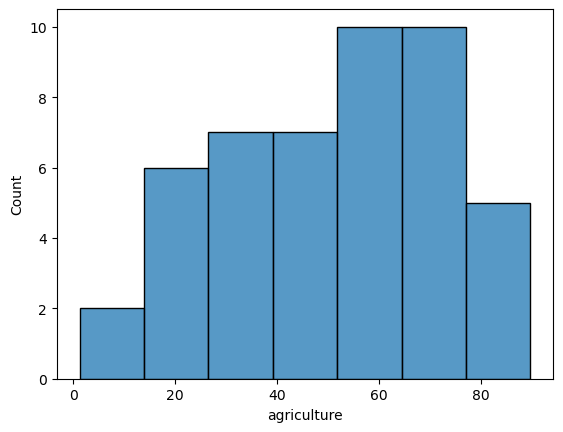

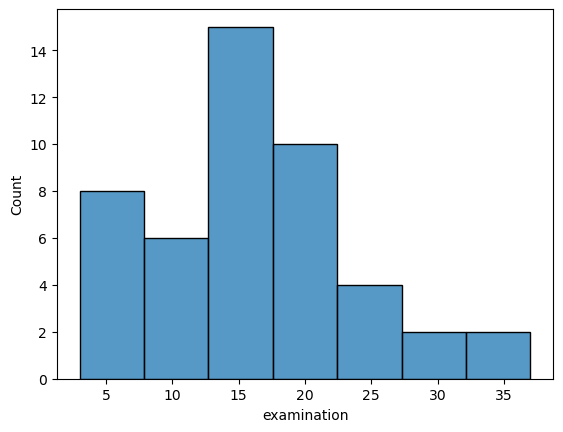

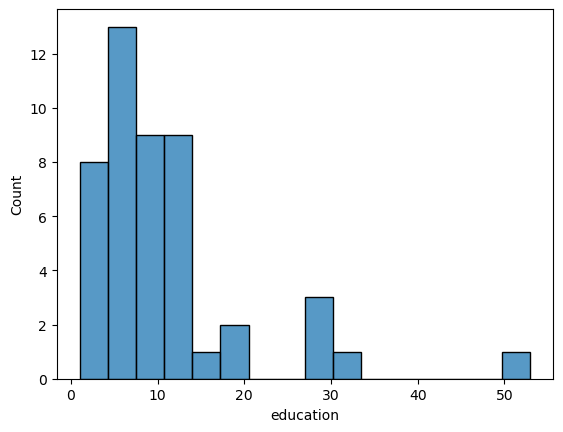

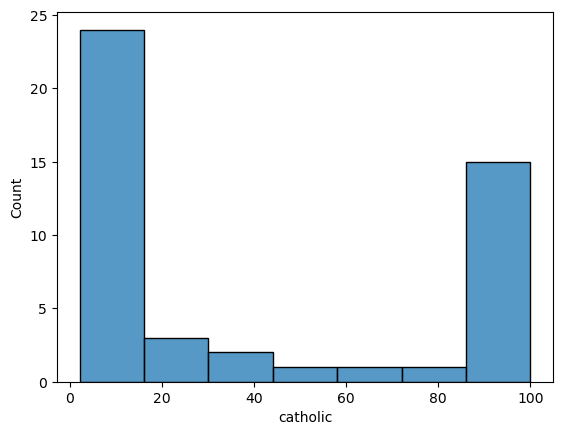

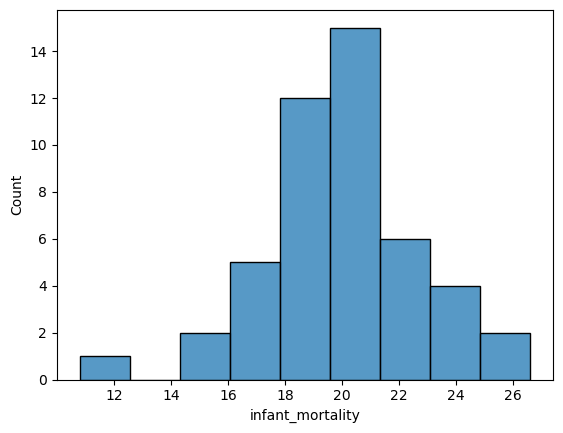

In [39]:
for col in df.columns[1:]:
    sns.histplot(df[col])
    plt.show()

In [42]:
# drop the region column and scale the rest
df = df.drop(columns=['region'])

,fertility,agriculture,examination,education,catholic,infant_mortality
0,80.2,17.0,15,12,9.96,22.2
1,83.1,45.1,6,9,84.84,22.2
2,92.5,39.7,5,5,93.40,20.2
3,85.8,36.5,12,7,33.77,20.3
4,76.9,43.5,17,15,5.16,20.6


In [74]:
# set the columns to scale, separate df into X and y (no splitting on this tiny dataset; practice only)
to_scale = ['infant_mortality', 'agriculture', 'examination', 'education', 'catholic']
X_df = df[to_scale]
y_series = df.fertility

In [75]:
# following code scales everything in the X_df (to_scale columns)
X_df_scaled = X_df.copy()
scaler = MinMaxScaler()
scaler.fit(X_df[to_scale])
X_df_scaled[to_scale] = scaler.transform(X_df[to_scale])
X_df_scaled.head()

,infant_mortality,agriculture,examination,education,catholic
0,0.721519,0.178531,0.352941,0.211538,0.079816
1,0.721519,0.496045,0.088235,0.153846,0.845069
2,0.594937,0.435028,0.058824,0.076923,0.932550
3,0.601266,0.398870,0.264706,0.115385,0.323148
4,0.620253,0.477966,0.411765,0.269231,0.030761


In [76]:
get_kbest_multi(X_df_scaled, y_series)

,Feature,KBest Rank,KBest Scores
0,education,1,35.445582
1,examination,2,32.208745
2,catholic,3,12.325096
3,infant_mortality,4,9.447708
4,agriculture,5,6.408884


In [77]:
get_rfe_multi(X_df_scaled, y_series)

,Feature,RFE Rank
3,education,1
0,infant_mortality,2
1,agriculture,3
4,catholic,4
2,examination,5


In [78]:
select_kbest(X_df_scaled, y_series, 3)

['examination', 'education', 'catholic']

In [79]:
select_rfe(X_df_scaled, y_series, 3)

['infant_mortality', 'agriculture', 'education']

### Fascinating. If I have time, I'm going to run this on different scalers

- I had time; there's actually a decent amount of variation within the different scalers (MinMax, Standard, Robust, QuantileTransformer
- So, I did a pairplot on the bottom. And now I see that fertility is the only feature that has much of an association. So this makes some sense. None of the other features are very closely related to infant_mortality
- I also ran a heatmap below, and you can see it even more clearly.  fertility has a ~.41 correlation coefficient. The rest are pretty low.

In [80]:
scaler = StandardScaler()
scaler.fit(X_df[to_scale])
X_df_scaled[to_scale] = scaler.transform(X_df[to_scale])
X_df_scaled.head()

,infant_mortality,agriculture,examination,education,catholic
0,0.783416,-1.498091,-0.188705,0.107361,-0.755810
1,0.783416,-0.247441,-1.329020,-0.208012,1.059075
2,0.089343,-0.487779,-1.455721,-0.628508,1.266546
3,0.124047,-0.630202,-0.568810,-0.418260,-0.178721
4,0.228158,-0.318652,0.064699,0.422733,-0.872149


In [81]:
get_kbest_multi(X_df_scaled, y_series)

,Feature,KBest Rank,KBest Scores
0,education,1,35.445582
1,examination,2,32.208745
2,catholic,3,12.325096
3,infant_mortality,4,9.447708
4,agriculture,5,6.408884


In [82]:
get_rfe_multi(X_df_scaled, y_series)

,Feature,RFE Rank
3,education,1
4,catholic,2
1,agriculture,3
0,infant_mortality,4
2,examination,5


In [83]:
scaler = RobustScaler()
scaler.fit(X_df[to_scale])
X_df_scaled[to_scale] = scaler.transform(X_df[to_scale])
X_df_scaled.head()

,infant_mortality,agriculture,examination,education,catholic
0,0.619718,-1.168504,-0.1,0.666667,-0.058910
1,0.619718,-0.283465,-1.0,0.166667,0.792676
2,0.056338,-0.453543,-1.1,-0.500000,0.890026
3,0.084507,-0.554331,-0.4,-0.166667,0.211873
4,0.169014,-0.333858,0.1,1.166667,-0.113499


In [84]:
get_kbest_multi(X_df_scaled, y_series)

,Feature,KBest Rank,KBest Scores
0,education,1,35.445582
1,examination,2,32.208745
2,catholic,3,12.325096
3,infant_mortality,4,9.447708
4,agriculture,5,6.408884


In [85]:
get_rfe_multi(X_df_scaled, y_series)

,Feature,RFE Rank
4,catholic,1
1,agriculture,2
3,education,3
0,infant_mortality,4
2,examination,5


In [86]:
scaler = QuantileTransformer()
scaler.fit(X_df[to_scale])
X_df_scaled[to_scale] = scaler.transform(X_df[to_scale])
X_df_scaled.head()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (47). n_quantiles is set to n_samples.
  warnings.warn(


,infant_mortality,agriculture,examination,education,catholic
0,0.771739,0.086957,0.456522,0.717391,0.413043
1,0.771739,0.369565,0.097826,0.565217,0.673913
2,0.543478,0.326087,0.054348,0.184783,0.760870
3,0.597826,0.260870,0.250000,0.369565,0.586957
4,0.652174,0.347826,0.608696,0.847826,0.239130


In [87]:
get_kbest_multi(X_df_scaled, y_series)

,Feature,KBest Rank,KBest Scores
0,examination,1,31.476237
1,education,2,14.237138
2,infant_mortality,3,9.657288
3,catholic,4,6.042546
4,agriculture,5,4.747012


In [88]:
get_rfe_multi(X_df_scaled, y_series)

,Feature,RFE Rank
2,examination,1
0,infant_mortality,2
3,education,3
1,agriculture,4
4,catholic,5


In [89]:
df.head()

,fertility,agriculture,examination,education,catholic,infant_mortality
0,80.2,17.0,15,12,9.96,22.2
1,83.1,45.1,6,9,84.84,22.2
2,92.5,39.7,5,5,93.40,20.2
3,85.8,36.5,12,7,33.77,20.3
4,76.9,43.5,17,15,5.16,20.6


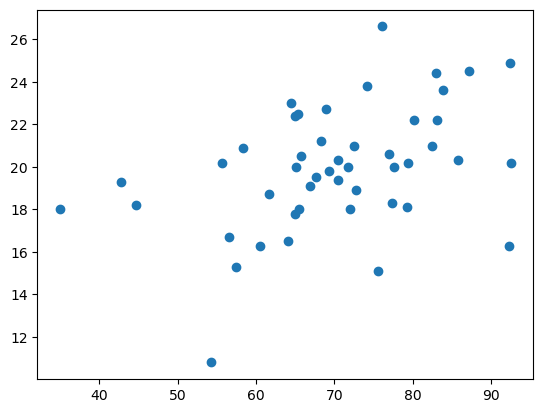

In [90]:
plt.scatter(df.fertility, df.infant_mortality)
plt.show()

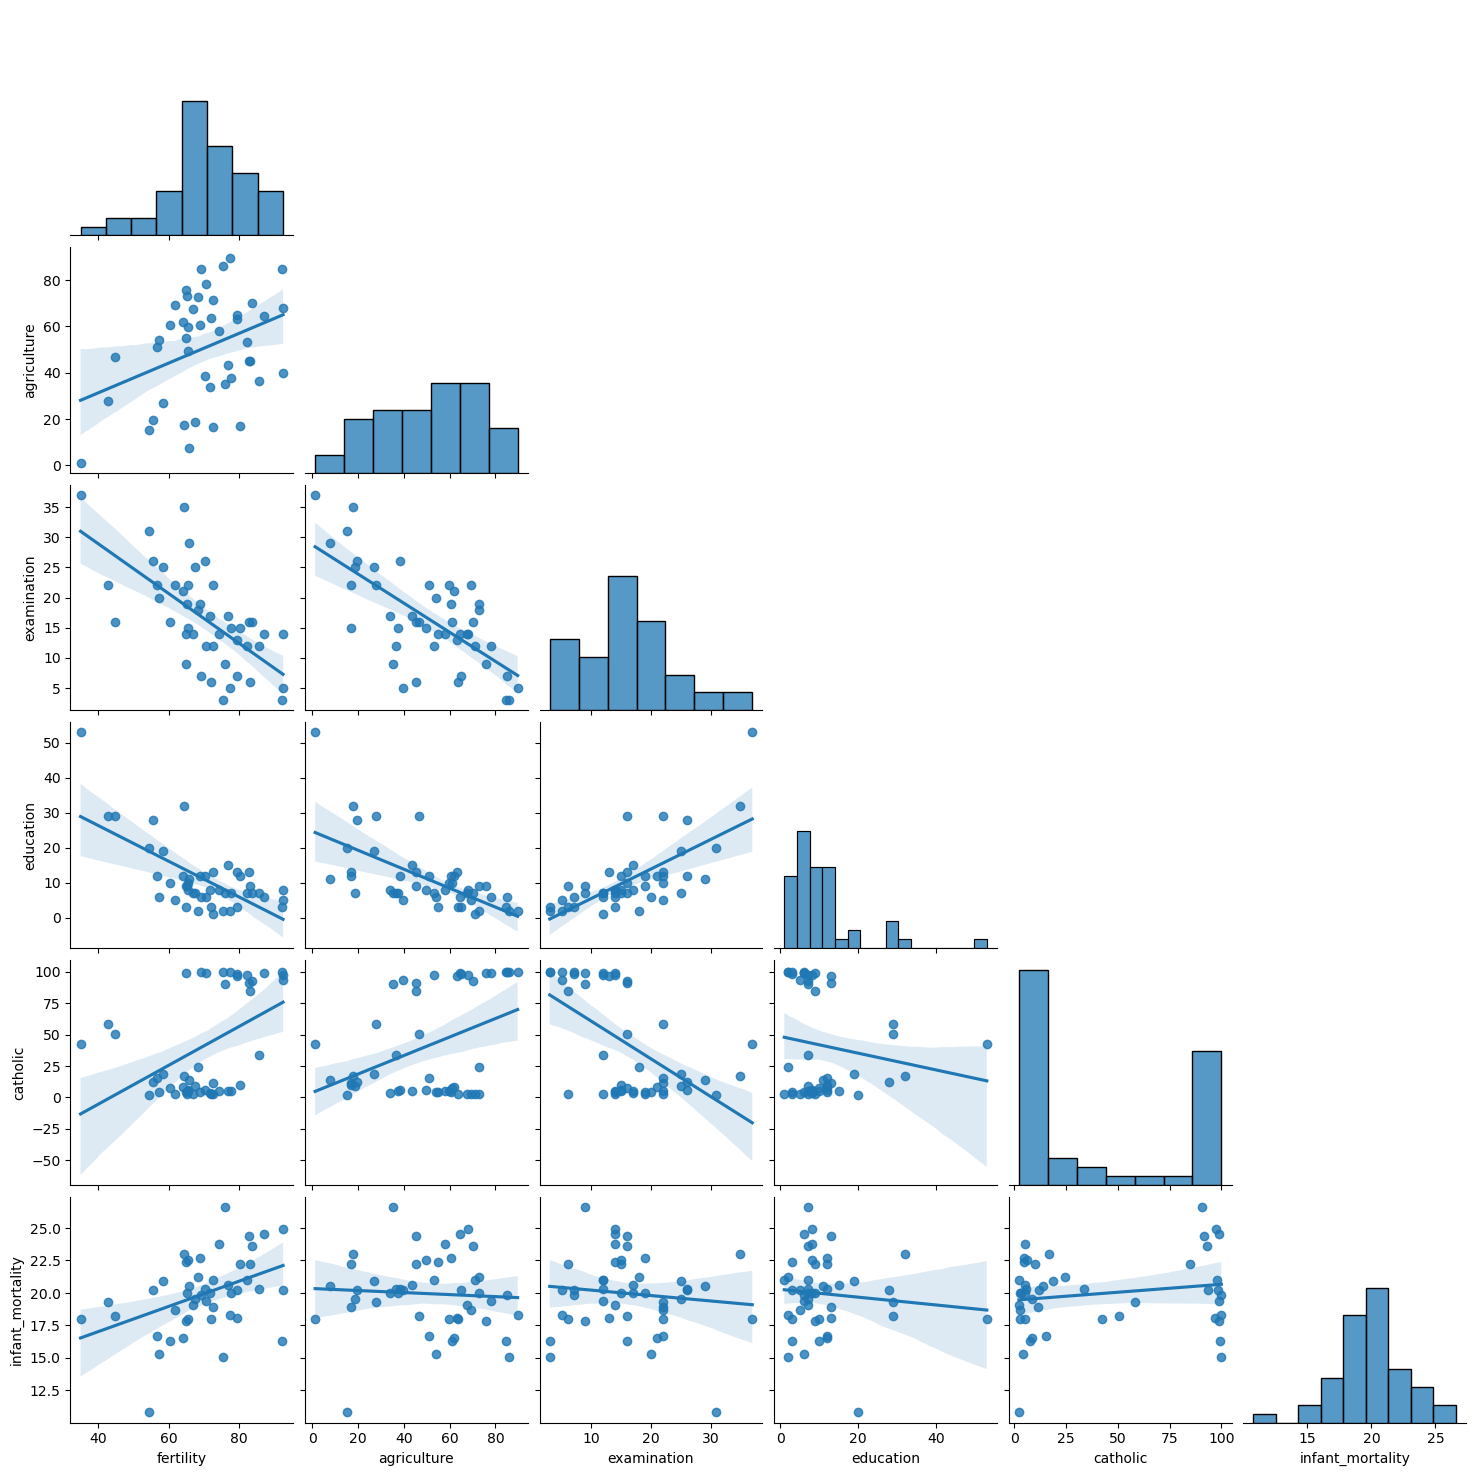

In [91]:
sns.pairplot(df, corner=True, kind='reg')

In [92]:
swiss_corr = df[df.columns].corr()

In [93]:
swiss_corr

,fertility,agriculture,examination,education,catholic,infant_mortality
fertility,1.000000,0.353079,-0.645883,-0.663789,0.463685,0.416556
agriculture,0.353079,1.000000,-0.686542,-0.639523,0.401095,-0.060859
examination,-0.645883,-0.686542,1.000000,0.698415,-0.572742,-0.114022
education,-0.663789,-0.639523,0.698415,1.000000,-0.153859,-0.099322
catholic,0.463685,0.401095,-0.572742,-0.153859,1.000000,0.175496
infant_mortality,0.416556,-0.060859,-0.114022,-0.099322,0.175496,1.000000


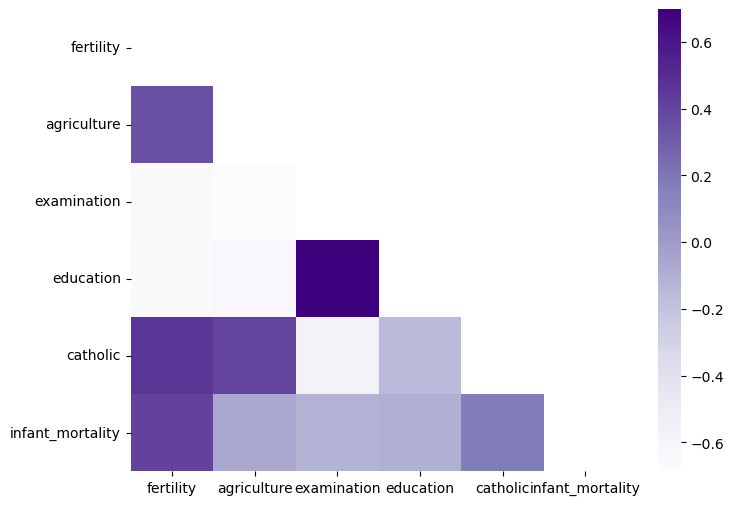

In [94]:
# Next, pass correlation matrix to sns.heatmap
plt.figure(figsize=(8,6))
sns.heatmap(swiss_corr, cmap='Purples', mask=np.triu(swiss_corr))
plt.show()